In [1]:
#import libraries
import pandas as pd
from time import time
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import lit
from pyspark.ml.feature import IndexToString
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit,CrossValidator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.sql.types import *
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

### Load preprocessed pickle file 

The preprocessed pickle file is converted into csv file and then start the spark session

In [2]:
#Load the dataset that contains userID, productID and ratings
df = pd.read_pickle('Preprocessed_data')
#Load the dataset which contains the titles/names of items
df_title = pd.read_pickle('Title_prod')

In [3]:
#Top 3 records of ratings dataset
df.head(3)

,overall,reviewerID,asin,reviewText,rev_date
0,4.0,A2MNB77YGJ3CN0,B00004R940,I'll admit it -- I'm a bit of a snob when it c...,2000-05-07
1,5.0,A1LUUO72VAFKFJ,B00004S4TZ,Maybe when Mom cooked for a big family every d...,2000-05-19
2,5.0,ALSQSIHU2ETLM,B00004RDAZ,"This was an impulse buy, I was looking for a b...",2000-05-31


In [4]:
#Top 3 records of titles dataset
df_title.head(3)

,asin,title
0,0001487795,You Are Special Today Red Plate [With Red Pen]
1,0002020300,Vicks Inhaler Relief for Cold Sinus Nasal Cong...
2,0006564224,Artistic Churchware Communion Cup Filler: RW525


In [5]:
#Dataset size
print("Total number of records in dataset: " ,df.shape[0])
print("Total number of records in title dataset: ", df_title.shape[0])

Total number of records in dataset:  6053296
Total number of records in title dataset:  1301225


In [6]:
#Removal of Date and Review text columns (Not necessary for our analysis)
df.drop('rev_date',axis=1,inplace=True)
df.drop('reviewText',axis=1,inplace=True)

In [7]:
#Displaying the modified dataset
df.head(1)

,overall,reviewerID,asin
0,4.0,A2MNB77YGJ3CN0,B00004R940


In [8]:
#Save the CSV datafile
df.to_csv('Preprocessed_data_csv', index=False)

In [9]:
#Save the CSV datafile
df_title.to_csv('title_data_csv', index=False)

### 1. Load the data into spark RDD dataframe

In [2]:
#Creating Spark Context
sc = SparkContext('local')
spark = SparkSession(sc)

In [3]:
#Creating a RDD
data = spark.read \
    .format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load("Preprocessed_data_csv")
data.withColumn('userId', data.reviewerID.cast(IntegerType()))
data.withColumn('asin', data.asin.cast(IntegerType()))
data.withColumn('overall', data.overall.cast(FloatType()))

DataFrame[overall: float, reviewerID: string, asin: string]

### 2. Analyzing dataset

In [13]:
data.show(5)

+-------+--------------+----------+
|overall|    reviewerID|      asin|
+-------+--------------+----------+
|    4.0|A2MNB77YGJ3CN0|B00004R940|
|    5.0|A1LUUO72VAFKFJ|B00004S4TZ|
|    5.0| ALSQSIHU2ETLM|B00004RDAZ|
|    2.0|A2E041EYGSY0HK|B00004S576|
|    5.0|A2RQOO8VYAEZZG|B00004SBIB|
+-------+--------------+----------+
only showing top 5 rows



In [14]:
#Dataset column details
data.printSchema()

root
 |-- overall: double (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- asin: string (nullable = true)



In [15]:
#Summary of the data
data.describe().show()

+-------+------------------+--------------------+--------------------+
|summary|           overall|          reviewerID|                asin|
+-------+------------------+--------------------+--------------------+
|  count|           6053296|             6053296|             6053296|
|   mean| 4.374284191620565|                null| 5.457612212007353E9|
| stddev|1.1174635054637467|                null|3.0129487134473906E9|
|    min|               1.0|A0001528BGUBOEVR6T5U|          0560467893|
|    max|               5.0|       AZZZYAYJQSDOJ|          B01HJGJNWS|
+-------+------------------+--------------------+--------------------+



In [16]:
print('Distinct values of ratings:')
print(sorted(data.select('overall').distinct().rdd.map(lambda r: r[0]).collect()))

Distinct values of ratings:
[1.0, 2.0, 3.0, 4.0, 5.0]


In [17]:
# Number of distict users and items
users = data.select("reviewerID").distinct().count()
items = data.select("asin").distinct().count()
print('Number of distinct users: ', users)
print('Number of distinct items: ', items)

Number of distinct users:  772925
Number of distinct items:  188138


In [18]:
#items which are rated by a single user
temp = sum(data.groupBy("asin").count().toPandas()['count'] == 1)
temp2 = data.select('asin').distinct().count()
print('{} out of {} items are rated by only one user'.format(temp, temp2))

1289 out of 188138 items are rated by only one user


In [10]:
data.createOrReplaceTempView('df_count')
# count number of ratings in each value of the rating(category)
ratingcount = spark.sql("""
      SELECT COUNT(overall) as count
      ,overall as rating
      FROM df_count
      GROUP BY overall
""")

counts = ratingcount.toPandas()
counts

,count,rating
0,312180,1.0
1,890974,4.0
2,450407,3.0
3,249045,2.0
4,4150690,5.0


### 4. Basic Visualization

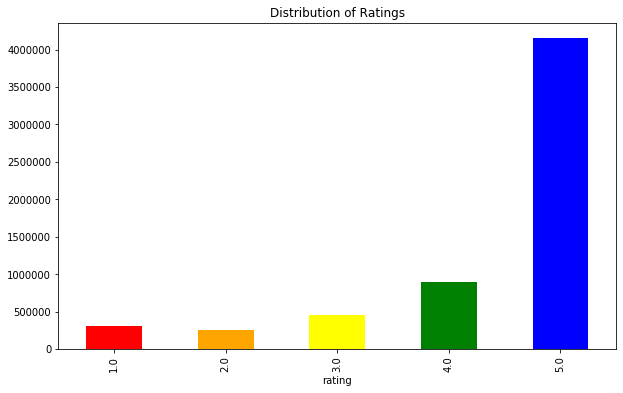

In [11]:
#Visualizing count of records with each type of ratings
colors = ['red', 'orange', 'yellow', 'green', 'blue']
counts.sort_values('rating',axis=0,inplace=True) # sorting 
counts.plot(x='rating',y='count',kind='bar',legend=False,color=colors,figsize=(10,6))
plt.title('Distribution of Ratings')
plt.show()

### 3. Preprocessing

In [4]:
#This step is used to reduce the sample size
df=data.sample(fraction=0.01)
df.count()

60193

#### Convert string type ID's to Integer

The Alternating Least Squares algorithm accepts userID and itemID only in integer format. 
We need to use STringIndexer to change ID's to integer/double format

In [5]:
#transform itemID and userID string type to index (integer type)

# Indexing for items
itemIndexer = StringIndexer(inputCol="asin", outputCol="item",handleInvalid='error')  
# Indexing for users
userIndexer = StringIndexer(inputCol='reviewerID',outputCol='userid',handleInvalid='error')

temp = itemIndexer.fit(df)
itemIndexed = temp.transform(df)

temp = userIndexer.fit(itemIndexed)
userIndexed = temp.transform(itemIndexed) 

# remove old columns - user and item ID's of string type
df_final = userIndexed.drop('asin').drop('reviewerID') 
df_final.show(5)

+-------+-------+-------+
|overall|   item| userid|
+-------+-------+-------+
|    5.0| 2170.0| 3621.0|
|    5.0| 1383.0|  482.0|
|    4.0|24403.0| 3169.0|
|    4.0|30652.0|11282.0|
|    5.0|26818.0|11129.0|
+-------+-------+-------+
only showing top 5 rows



In [6]:
# renaming columns 
df_final = df_final.selectExpr("userid as userID","item as productID","overall as rating")

In [7]:
df_final.show(n=5)

+-------+---------+------+
| userID|productID|rating|
+-------+---------+------+
| 3621.0|   2170.0|   5.0|
|  482.0|   1383.0|   5.0|
| 3169.0|  24403.0|   4.0|
|11282.0|  30652.0|   4.0|
|11129.0|  26818.0|   5.0|
+-------+---------+------+
only showing top 5 rows



In [8]:
df_final.printSchema()

root
 |-- userID: double (nullable = false)
 |-- productID: double (nullable = false)
 |-- rating: double (nullable = true)



In [26]:
#Save the preprocessed file to local
als_data = df_temp.toPandas()
als_data.to_csv('als_preprocessed1.csv', index = False)

In [14]:
#Save the preprocessed file to local
als_data = df_final.toPandas()
als_data.to_csv('als_preprocessed.csv', index = False)

### 5. Divide data into train-validation-test dataset

In [9]:
# 60-20-20 train-test-validation split
(train, validation, test) = df_final.randomSplit([0.6,0.2,0.2])

# cache into memory through clusters so that we can access this data frequently 
train.cache() 
validation.cache()
test.cache()

# Each dataset size
print('Train dataset size: ', train.count())
print('Validation dataset size: ', validation.count())
print('Test dataset size: ' ,test.count())

Train dataset size:  35990
Validation dataset size:  12078
Test dataset size:  12125


In [23]:
print('Matrix size, percentage of matrix filled and number of distinct users and itmes:')
# calculate percentage of the user-item matrix that is filled
train.createOrReplaceTempView('train')
spark.sql("""
      SELECT *, 100 * rating/matrix_size AS percentage
        FROM (
          SELECT userID, productID, rating, userID * productID AS matrix_size
            FROM(
              SELECT COUNT(*) AS rating, COUNT(DISTINCT(productID)) AS productID, COUNT(DISTINCT(userID)) AS userID
                FROM train
                )
            )
""").show()

Matrix size, percentage of matrix filled and number of distinct users and itmes:
+------+---------+------+-----------+-------------------+
|userID|productID|rating|matrix_size|         percentage|
+------+---------+------+-----------+-------------------+
| 35209|    23935| 36350|  842727415|0.00431337575507734|
+------+---------+------+-----------+-------------------+



### 6. ALS on entire Training Dataset

In [10]:
#Defining the model
als = ALS(userCol="userID", itemCol="productID", ratingCol="rating",coldStartStrategy='drop',nonnegative = True)

# Error evaluation
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

In [11]:
# hyper-parameter config
grid_para = ParamGridBuilder()\
        .addGrid(als.rank, [1, 5, 10,15,30]) \
        .addGrid(als.maxIter, [10])\
        .addGrid(als.regParam, [0.05, 0.1, 0.5,1])\
        .build()

In [12]:
# train validation split
tvs = TrainValidationSplit(estimator= als,
                           estimatorParamMaps= grid_para,
                           evaluator= evaluator,
                           trainRatio= 0.8)

In [13]:
# fit model and calculate time
start = time()
model = tvs.fit(train)
end = time()
tot_time = (end - start)

print('Total time taken: ', tot_time)

Total time taken:  707.9941310882568


### 7. Calculate RMSE on Test Dataset

In [14]:
# predict and evaluate test set
predictions = model.transform(test)
rmse = evaluator.evaluate(predictions)

print('Test set RMSE: ',rmse)

Test set RMSE:  3.1684938739227855


In [15]:
#display predictions and actual rating for test data
predictions.sort(["userID","rating"]).show(20)

+------+---------+------+----------+
|userID|productID|rating|prediction|
+------+---------+------+----------+
|   0.0|    274.0|   5.0| 0.6219561|
|   2.0|   3111.0|   5.0|0.93746805|
|   2.0|   2985.0|   5.0| 2.5746665|
|   4.0|    255.0|   5.0| 1.3971246|
|   5.0|   2095.0|   5.0| 1.8063544|
|  14.0|   3202.0|   5.0| 0.7001703|
|  14.0|   3606.0|   5.0| 1.5837868|
|  17.0|     66.0|   4.0| 1.9827803|
|  18.0|   1170.0|   5.0| 2.8749843|
|  20.0|   4410.0|   4.0| 0.6155535|
|  27.0|   4126.0|   2.0| 1.6883835|
|  39.0|    370.0|   4.0| 1.5242931|
|  44.0|   1671.0|   1.0| 2.1991313|
|  46.0|    170.0|   3.0| 1.5318563|
|  46.0|    568.0|   5.0| 2.3525789|
|  54.0|   2834.0|   4.0|  1.021477|
|  56.0|   4517.0|   5.0| 0.8964698|
|  59.0|   9071.0|   5.0| 1.2695558|
|  60.0|    650.0|   5.0| 1.8200127|
|  61.0|   3445.0|   5.0| 1.1902363|
+------+---------+------+----------+
only showing top 20 rows



### 8. Recommend of Items for a User

#### Filter out items rated by a specific user and make predictions of ratings for the items rated by that user.

In [23]:
train.show(n=10)

+------+---------+------+
|userID|productID|rating|
+------+---------+------+
|   0.0|   2947.0|   2.0|
|   0.0|   7458.0|   4.0|
|   0.0|   8346.0|   5.0|
|   0.0|  24312.0|   5.0|
|   1.0|   2364.0|   5.0|
|   1.0|   3863.0|   5.0|
|   1.0|  24709.0|   5.0|
|   2.0|    154.0|   5.0|
|   2.0|  31262.0|   5.0|
|   2.0|  32921.0|   4.0|
+------+---------+------+
only showing top 10 rows



In [24]:
# Create a dataset with distinct games as one column and the user of interest as another column
user_item = train.select("productID").distinct().withColumn("userID", lit(32921.0))
user_item.show()

+---------+-------+
|productID| userID|
+---------+-------+
|    934.0|32921.0|
|   9923.0|32921.0|
|    496.0|32921.0|
|  13918.0|32921.0|
|  13607.0|32921.0|
|  12467.0|32921.0|
|  16561.0|32921.0|
|  21933.0|32921.0|
|  29243.0|32921.0|
|   6765.0|32921.0|
|  15893.0|32921.0|
|  26381.0|32921.0|
|  14473.0|32921.0|
|    596.0|32921.0|
|    305.0|32921.0|
|  16916.0|32921.0|
|  14452.0|32921.0|
|    769.0|32921.0|
|  26597.0|32921.0|
|  16981.0|32921.0|
+---------+-------+
only showing top 20 rows



In [25]:
# filter out items that user has already rated 
rated = train.filter(train.userID == 32921.0).select("productID", "userID")

In [27]:
# apply trained recommender system
predict = model.transform(user_item.subtract(rated)).dropna().select("productID", "prediction")
#display predictions and actual rating for test data
predict.show(20)

+---------+----------+
|productID|prediction|
+---------+----------+
|    148.0| 0.6021734|
|    463.0| 1.0332255|
|    471.0| 1.4597299|
|    496.0| 0.9136216|
|    833.0| 1.5073291|
|   1088.0|0.52151436|
|   1238.0| 0.9913304|
|   1342.0| 0.8306353|
|   1580.0| 1.0909708|
|   1591.0|0.41711172|
|   1645.0| 0.5466585|
|   1829.0|0.14468849|
|   1959.0|  1.318557|
|   2122.0| 1.8428688|
|   2142.0| 1.0749868|
|   2366.0| 1.0013459|
|   2659.0| 1.6838344|
|   2866.0| 1.9651259|
|   3175.0|0.53722996|
|   3749.0|0.68655676|
+---------+----------+
only showing top 20 rows



In [28]:
# convert index back to original ASIN 
original = IndexToString(inputCol="productID", outputCol="productID_old")
df_convert = original.transform(predict)
print('The predictions for the items rated by userID => 32921 are:')
df_convert.show()

The predictions for the items rated by userID => 32921 are:
+---------+----------+-------------+
|productID|prediction|productID_old|
+---------+----------+-------------+
|    148.0| 0.6021734|   B001802PIQ|
|    463.0| 1.0332255|   B003Y3AA2S|
|    471.0| 1.4597299|   B015NBNRZK|
|    496.0| 0.9136216|   B00RO6KP6M|
|    833.0| 1.5073291|   B003L0OOUS|
|   1088.0|0.52151436|   B005SPEV66|
|   1238.0| 0.9913304|   B00F0A6GDU|
|   1342.0| 0.8306353|   B01EL2N9FU|
|   1580.0| 1.0909708|   B00GS0L7CQ|
|   1591.0|0.41711172|   B005NBRKXQ|
|   1645.0| 0.5466585|   B008TYX1LO|
|   1829.0|0.14468849|   B002451AB2|
|   1959.0|  1.318557|   B00E58O57M|
|   2122.0| 1.8428688|   B01AH488VQ|
|   2142.0| 1.0749868|   B00COC9P4E|
|   2366.0| 1.0013459|   B0016KXR4Y|
|   2659.0| 1.6838344|   B00004SGFD|
|   2866.0| 1.9651259|   B001G97FLQ|
|   3175.0|0.53722996|   B015AV2R90|
|   3749.0|0.68655676|   B01A7PICSO|
+---------+----------+-------------+
only showing top 20 rows



### 9. Adding the titles for each product

#### Here, the titles dataset is imported from the metadata. The dataset consists:
> 1. Asin : Item/product ID
> 2. Title: Name of the corresponding product <br>

This data is merged with our predictions to know the `titles` for the respective `product IDs`.

In [29]:
#Load the titles dataset
title = spark.read.load('title_data_csv', format='csv', header=True, inferSchema=True)

In [30]:
df_convert.createOrReplaceTempView('result')
title.createOrReplaceTempView('titles')
final = spark.sql("""
      SELECT m.productID_old as productID,
      m.prediction,
      d.title
      FROM result m LEFT JOIN titles d ON m.productID_old = d.asin
      WHERE m.productID_old IS NOT NULL
      """)

In [37]:
final = final.dropDuplicates(['productID'])
final.show()

+----------+----------+--------------------+
| productID|prediction|               title|
+----------+----------+--------------------+
|B00005IX9T|0.12071096|Braun KF400-WH Ar...|
|B0000665TD| 1.6201854|J-2000 Jiffy Garm...|
|B00061J2B6| 1.4893143|Steamfast SF-680 ...|
|B000A2M2EK| 0.9939964|Universal Slicer/...|
|B000I0WQWC| 2.5426176|Holmes Arm and Ha...|
|B000LNS2HE| 1.6467295|Anchor Hocking Gl...|
|B000SP65HO|0.42966834|Boss Office Produ...|
|B000TVVMNY| 1.4171958|instecho Beer Bar...|
|B000X6K9J8|  1.639034|EZ Off Jar Opener...|
|B000XB8K6C|0.76004446|Emile Henry Butte...|
|B000ZPGB62| 0.6162847|Cozy Sack 7-Feet ...|
|B000ZRXMJ4| 1.2890935|Lock & Lock 7.6 C...|
|B0012BU6TQ|0.43128937|ANBOO Steam Mop P...|
|B0015HEABW| 2.2693975|16 oz. Olive Oil ...|
|B001AO1X1U| 0.8082084|Sunbeam 2551 Heri...|
|B001B14OC2| 1.9981458|Regency Turkey La...|
|B001FNVXS4|0.64549565|var aPageStart = ...|
|B001G0PMW4| 1.1114763|Mountain Woods 15...|
|B001I7FP54| 1.5823683|Deluxe Food Strai...|
|B001KZC2R

### 10. Adding links to the products (Amazon Website)

In [32]:
from IPython.display import HTML

In [38]:
df_links = final.toPandas()
df_links.head(5)

,productID,prediction,title
0,B00005IX9T,0.120711,"Braun KF400-WH Aromaster 10-Cup Coffeemaker, W..."
1,B0000665TD,1.620185,J-2000 Jiffy Garment Steamer with Plastic Stea...
2,B00061J2B6,1.489314,Steamfast SF-680 Digital Steam Press with Mult...
3,B000A2M2EK,0.993996,Universal Slicer/Shredder with Three Discs
4,B000I0WQWC,2.542618,Holmes Arm and Hammer Air Purifier Booster Fil...


In [39]:
df_links = df_links.iloc[0:20]

In [40]:
df_links['Link'] = df_links['productID'].apply(
                lambda x: '<a href="https://www.amazon.com/gp/product/{}">link</a>'.format(x))

In [41]:
print("Top 20 recommendations for the userID => 32921 are:")
HTML(df_links.to_html(render_links=True,escape=False))

Top 20 recommendations for the userID => 32921 are:


,productID,prediction,title,Link
0,B00005IX9T,0.120711,"Braun KF400-WH Aromaster 10-Cup Coffeemaker, White",link
1,B0000665TD,1.620185,"J-2000 Jiffy Garment Steamer with Plastic Steam Head, 120 Volt",link
2,B00061J2B6,1.489314,"Steamfast SF-680 Digital Steam Press with Multiple Fabric Settings and Steam Burst Function,Stainless/Black",link
3,B000A2M2EK,0.993996,Universal Slicer/Shredder with Three Discs,link
4,B000I0WQWC,2.542618,"Holmes Arm and Hammer Air Purifier Booster Filter, 4 Pack",link
5,B000LNS2HE,1.646729,"Anchor Hocking Glass Prep Bowls Custard Cups, 6 Ounce, Set of 4",link
6,B000SP65HO,0.429668,Boss Office Products B1690-CS Stand Up Caressoft Drafting Stool without Arms in Black,link
7,B000TVVMNY,1.417196,instecho Beer Bar Blade Bottle Opener,link
8,B000X6K9J8,1.639034,"EZ Off Jar Opener For All Jar Sizes, White",link
9,B000XB8K6C,0.760044,"Emile Henry Butter Pot, Figue",link


Check for the product details on amazon website by clicking on the respective link

![](amazon_img.jpg)